<a href="https://colab.research.google.com/github/valthoraval/stochastic/blob/master/Project_Market_Day_checkpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project - Market Day

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://supaerodatascience.github.io/stochastic/">https://supaerodatascience.github.io/stochastic/</a>

![Stardew Valley](https://venturebeat.com/wp-content/uploads/2018/01/sw7rtba7p1xs77klsime.png)

It is Market Day! You've been working hard for a whole season, planting, watering, and taking care of crops. Now it is time to sell them in town. Just one problem though - your old truck can only carry so much weight. Which crops should you bring to maximize your profits? 

In this project, you will use a stochastic algorithm of your choice to find the best crop configuration you can load into your truck. You know how much stock you have of each crop, how much each crop weighs, and what price it will fetch at the market. You should use these values throughout the project.

Before we start, if you're using colab to run this notebook, you'll need to uncomment and run the following lines:

In [1]:
!wget https://raw.githubusercontent.com/SupaeroDataScience/stochastic/master/project/market.csv
!wget https://raw.githubusercontent.com/SupaeroDataScience/stochastic/master/project/recipes.csv
!pip install pymoo

--2022-12-03 17:53:52--  https://raw.githubusercontent.com/SupaeroDataScience/stochastic/master/project/market.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 927 [text/plain]
Saving to: ‘market.csv’

market.csv          100%[===================>]     927  --.-KB/s    in 0s      

2022-12-03 17:53:52 (26.9 MB/s) - ‘market.csv’ saved [927/927]

--2022-12-03 17:53:53--  https://raw.githubusercontent.com/SupaeroDataScience/stochastic/master/project/recipes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 388 [text/plain]
Savin

In [221]:
import numpy as np
import pandas as pd
import pymoo
import copy

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math

import random

In [86]:
df = pd.read_csv('market.csv', index_col=0)
df.head()

,stock,weight,price_A,price_B,price_C
Apple,5,5,1.00,0.5,1.1
Apricot,65,3,0.50,0.2,0.6
Blueberry,5,3,0.50,0.3,1.2
Cactus Fruit,90,4,0.75,0.3,0.3
Cherry,15,4,0.80,0.4,1.1


In [4]:
stock = df['stock'].to_dict()
weight = df['weight'].to_dict()
price = df['price_A'].to_dict()

In [87]:
stock

{'Apple': 5,
 'Apricot': 65,
 'Blueberry': 5,
 'Cactus Fruit': 90,
 'Cherry': 15,
 'Cranberry': 75,
 'Grape': 70,
 'Melon': 75,
 'Orange': 40,
 'Peach': 55,
 'Pomegranate': 5,
 'Rhubarb': 70,
 'Starfruit': 5,
 'Strawberry': 20,
 'Amaranth': 20,
 'Artichoke': 65,
 'Beet': 30,
 'Bok Choy': 55,
 'Cauliflower': 70,
 'Corn': 90,
 'Eggplant': 95,
 'Garlic': 95,
 'Green Bean': 55,
 'Hops': 75,
 'Hot Pepper': 25,
 'Kale': 5,
 'Parsnip': 10,
 'Potato': 55,
 'Pumpkin': 30,
 'Radish': 50,
 'Red Cabbage': 55,
 'Tomato': 65,
 'Wheat': 75,
 'Yam': 50,
 'Blackberry': 70}

To evaluate your possible load going to the market, we will use a function that takes in a dictionary of this type, specifying how many of each crop you will take. This function will take into the constraints of having enough stock of the crop type and of not surpassing the weight limit.

In [88]:
def evaluate(load, stock, weight, price, max_weight=5000):
    total_weight = 0
    total_price = 0
    for k in load:
        if load[k] <= stock[k]:
            total_price += load[k] * price[k]
            total_weight += load[k] * weight[k]
            if total_weight > max_weight:
                return 0
        else:
            return 0
    return total_price

In [89]:
def evaluate_autre(load, stock, weight, price, max_weight=5000):
    total_weight = 0
    total_price = 0
    for k in load:
        if load[k] <= stock[k]:
            total_price += load[k] * price[k]
            total_weight += load[k] * weight[k]
            if total_weight > max_weight:
                total_price -= load[k] * price[k]
                total_weight -= load[k] * weight[k]
                break
        else:
            pass
    print("Total weight", total_weight)
    return total_price

In [90]:
def toDict(lst):
    res_dct = {lst[i][0] : lst[i][1] for i in range(0, len(lst))}
    return res_dct

You can try this with an example load generated randomly:

In [91]:
trial_load = {}

for k in stock:
    trial_load[k] = np.random.randint(0, stock[k])

print(trial_load)
type(trial_load)
print(list(trial_load.items())[:10])
dict_1 = toDict(list(trial_load.items())[:10])
print(dict_1)
dict_2 = toDict(list(trial_load.items())[10:])
print(dict_2)
print({**dict_1, **dict_2})

{'Apple': 2, 'Apricot': 43, 'Blueberry': 4, 'Cactus Fruit': 43, 'Cherry': 14, 'Cranberry': 4, 'Grape': 20, 'Melon': 29, 'Orange': 36, 'Peach': 24, 'Pomegranate': 2, 'Rhubarb': 49, 'Starfruit': 0, 'Strawberry': 18, 'Amaranth': 19, 'Artichoke': 33, 'Beet': 27, 'Bok Choy': 24, 'Cauliflower': 14, 'Corn': 18, 'Eggplant': 87, 'Garlic': 3, 'Green Bean': 6, 'Hops': 55, 'Hot Pepper': 14, 'Kale': 2, 'Parsnip': 7, 'Potato': 40, 'Pumpkin': 10, 'Radish': 36, 'Red Cabbage': 40, 'Tomato': 23, 'Wheat': 1, 'Yam': 9, 'Blackberry': 34}
[('Apple', 2), ('Apricot', 43), ('Blueberry', 4), ('Cactus Fruit', 43), ('Cherry', 14), ('Cranberry', 4), ('Grape', 20), ('Melon', 29), ('Orange', 36), ('Peach', 24)]
{'Apple': 2, 'Apricot': 43, 'Blueberry': 4, 'Cactus Fruit': 43, 'Cherry': 14, 'Cranberry': 4, 'Grape': 20, 'Melon': 29, 'Orange': 36, 'Peach': 24}
{'Pomegranate': 2, 'Rhubarb': 49, 'Starfruit': 0, 'Strawberry': 18, 'Amaranth': 19, 'Artichoke': 33, 'Beet': 27, 'Bok Choy': 24, 'Cauliflower': 14, 'Corn': 18, 'Eg

In [92]:
print(list(trial_load.values())[5])
print(list(trial_load.keys())[5])
trial_2 = trial_load.copy()
print(trial_2)
trial_2.update({str(list(trial_load.keys())[5]):20})
print(trial_2)

4
Cranberry
{'Apple': 2, 'Apricot': 43, 'Blueberry': 4, 'Cactus Fruit': 43, 'Cherry': 14, 'Cranberry': 4, 'Grape': 20, 'Melon': 29, 'Orange': 36, 'Peach': 24, 'Pomegranate': 2, 'Rhubarb': 49, 'Starfruit': 0, 'Strawberry': 18, 'Amaranth': 19, 'Artichoke': 33, 'Beet': 27, 'Bok Choy': 24, 'Cauliflower': 14, 'Corn': 18, 'Eggplant': 87, 'Garlic': 3, 'Green Bean': 6, 'Hops': 55, 'Hot Pepper': 14, 'Kale': 2, 'Parsnip': 7, 'Potato': 40, 'Pumpkin': 10, 'Radish': 36, 'Red Cabbage': 40, 'Tomato': 23, 'Wheat': 1, 'Yam': 9, 'Blackberry': 34}
{'Apple': 2, 'Apricot': 43, 'Blueberry': 4, 'Cactus Fruit': 43, 'Cherry': 14, 'Cranberry': 20, 'Grape': 20, 'Melon': 29, 'Orange': 36, 'Peach': 24, 'Pomegranate': 2, 'Rhubarb': 49, 'Starfruit': 0, 'Strawberry': 18, 'Amaranth': 19, 'Artichoke': 33, 'Beet': 27, 'Bok Choy': 24, 'Cauliflower': 14, 'Corn': 18, 'Eggplant': 87, 'Garlic': 3, 'Green Bean': 6, 'Hops': 55, 'Hot Pepper': 14, 'Kale': 2, 'Parsnip': 7, 'Potato': 40, 'Pumpkin': 10, 'Radish': 36, 'Red Cabbage':

In [93]:
evaluate(trial_load, stock, weight, price)

686.5999999999999

## Challenge 1

Use a stochastic algorithm to find the configuration of crops that maximizes profit while respecting the constraints of the weight limit and stock. You can use any of the class code or a library like `pymoo`. You should create a reasonable representation for the problem and appropriate modification functions like mutation and crossover. You can also modify the evaluation function, as long as your final solution is valid according to the weight and stock constraints.

Include your code for optimization, any visualizations of the optimization process, as well as code to show the final market load and profit gained. Can you beat the random trial load profits?

Hint: this is a constrained case of the [knapsack problem](https://en.wikipedia.org/wiki/Knapsack_problem)

In [222]:
n_population = 100
population_trail_load = []

for i in range(n_population):
    trial_load = {}
    for k in stock:
        trial_load[k] = np.random.randint(0, stock[k])
    population_trail_load.append(trial_load)
#trial_load
len(population_trail_load)
print(population_trail_load[20])
print(type(population_trail_load[20]))

print(len(population_trail_load))

{'Apple': 3, 'Apricot': 51, 'Blueberry': 3, 'Cactus Fruit': 82, 'Cherry': 10, 'Cranberry': 22, 'Grape': 6, 'Melon': 32, 'Orange': 29, 'Peach': 18, 'Pomegranate': 4, 'Rhubarb': 45, 'Starfruit': 1, 'Strawberry': 15, 'Amaranth': 0, 'Artichoke': 38, 'Beet': 19, 'Bok Choy': 17, 'Cauliflower': 68, 'Corn': 8, 'Eggplant': 76, 'Garlic': 24, 'Green Bean': 39, 'Hops': 16, 'Hot Pepper': 7, 'Kale': 2, 'Parsnip': 4, 'Potato': 25, 'Pumpkin': 21, 'Radish': 18, 'Red Cabbage': 18, 'Tomato': 60, 'Wheat': 35, 'Yam': 12, 'Blackberry': 56}
<class 'dict'>
100


In [129]:
def evaluate_population(population):
    fit = []
    for i in range(len(population)):
        prix = evaluate(population[i], stock, weight, price)
        fit.append(prix)
    return fit

In [223]:
fitness = evaluate_population(population_trail_load)
print(fitness)

[686.9500000000002, 615.3000000000001, 763.5999999999999, 704.2500000000001, 727.3000000000001, 0, 807.1500000000002, 551.4, 844.25, 836.0999999999999, 738.3500000000001, 530.4999999999999, 563.05, 602.1, 538.7, 585.6499999999999, 612.05, 608.3500000000001, 650.45, 811.6999999999999, 755.3500000000001, 814.8500000000001, 588.35, 689.8, 842.3999999999999, 779.9000000000001, 709.9000000000001, 601.5999999999999, 734.6, 703.4000000000002, 673.8499999999999, 765.5499999999997, 695.2999999999997, 720.0500000000002, 609.7, 711.8000000000001, 811.5500000000002, 686.7499999999998, 801.85, 0, 768.2, 738.65, 699.1, 718.5500000000002, 693.6500000000001, 695.9999999999999, 722.9499999999999, 867.4500000000002, 841.35, 775.8, 0, 0, 627.6000000000001, 729.5, 744.5000000000002, 733.4499999999998, 864.6999999999999, 688.7499999999999, 832.9500000000002, 718.35, 696.9000000000002, 800.7, 819.7000000000002, 687.4499999999998, 0, 622.1000000000001, 657.3, 631.5000000000001, 504.00000000000006, 764.849999

In [250]:
def fp_selection(population, fitness):
    m = max(fitness)
    p = np.zeros(len(fitness))
    for i in range(len(fitness)):
        p[i] = (m - fitness[i])
    p /= sum(p)
    rng = np.random.default_rng()
    n = len(population)
    #continueSelection = True
    '''
    while(continueSelection):
        ind = rng.choice(n, p=p)
        #print(ind)
        if(fitness[ind] != 0):
           continueSelection = False
    '''
    ind = rng.choice(n, p=p)
    return population[ind], fitness[ind]

20


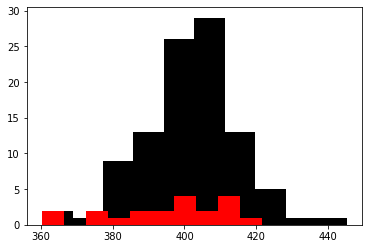

In [145]:
fp_fits = np.zeros(20)
for i in range(20):
    p, f = fp_selection(population_trail_load, fitness)
    fp_fits[i] = f
plt.hist(fitness, color='k')
#plt.hist(efit, color='b')
plt.hist(fp_fits, color='r');
print(fp_fits.size)

In [169]:
def truncation_selection(population, fitness, p=0.2):
    n_elites = len(population) - int(np.floor(len(population) * p))
    #print(n_elites)
    elites = np.argsort(np.array(fitness))[n_elites:]
    selected_pop, selected_fitness = [], []
    for index in elites:
        selected_pop.append(population[index])
        selected_fitness.append(fitness[index])
    return selected_pop, selected_fitness

80
elites [{'Apple': 2, 'Apricot': 34, 'Blueberry': 3, 'Cactus Fruit': 80, 'Cherry': 1, 'Cranberry': 28, 'Grape': 62, 'Melon': 18, 'Orange': 9, 'Peach': 49, 'Pomegranate': 4, 'Rhubarb': 46, 'Starfruit': 4, 'Strawberry': 19, 'Amaranth': 4, 'Artichoke': 39, 'Beet': 14, 'Bok Choy': 52, 'Cauliflower': 2, 'Corn': 7, 'Eggplant': 85, 'Garlic': 18, 'Green Bean': 16, 'Hops': 71, 'Hot Pepper': 2, 'Kale': 2, 'Parsnip': 3, 'Potato': 51, 'Pumpkin': 12, 'Radish': 0, 'Red Cabbage': 50, 'Tomato': 7, 'Wheat': 16, 'Yam': 7, 'Blackberry': 1}, {'Apple': 2, 'Apricot': 8, 'Blueberry': 3, 'Cactus Fruit': 17, 'Cherry': 8, 'Cranberry': 34, 'Grape': 47, 'Melon': 4, 'Orange': 33, 'Peach': 38, 'Pomegranate': 2, 'Rhubarb': 45, 'Starfruit': 0, 'Strawberry': 5, 'Amaranth': 14, 'Artichoke': 33, 'Beet': 12, 'Bok Choy': 29, 'Cauliflower': 29, 'Corn': 85, 'Eggplant': 79, 'Garlic': 66, 'Green Bean': 7, 'Hops': 27, 'Hot Pepper': 20, 'Kale': 4, 'Parsnip': 4, 'Potato': 23, 'Pumpkin': 16, 'Radish': 43, 'Red Cabbage': 16, 'To

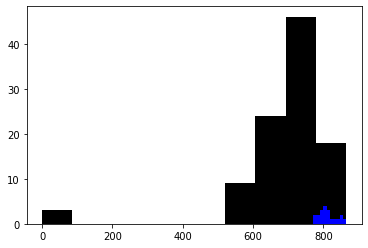

In [159]:
p_elites, efit = truncation_selection(population_trail_load, fitness)
plt.hist(fitness, color='k')
plt.hist(efit, color='b');
print('elites',p_elites,len(p_elites))
print(len(p_elites), len(efit), len(population_trail_load), len(fitness))

In [131]:
def tournament_selection(population, fitness, t_size=3):
    rng = np.random.default_rng()
    tournament = rng.choice(len(population), size=t_size)
    #print('tournament',type(tournament))
    #print('tournament', tournament)
    ind = []
    for i in range(len(tournament)):
        ind.append(fitness[tournament[i]])
    ind = ind.index(max(ind))
    return population[ind], fitness[ind]


In [120]:
for j in range(5):
    p, f = tournament_selection(population_trail_load, fitness, t_size=3)
    print(p)
    print(f)

{'Apple': 3, 'Apricot': 22, 'Blueberry': 3, 'Cactus Fruit': 4, 'Cherry': 7, 'Cranberry': 68, 'Grape': 23, 'Melon': 64, 'Orange': 13, 'Peach': 50, 'Pomegranate': 3, 'Rhubarb': 66, 'Starfruit': 0, 'Strawberry': 5, 'Amaranth': 5, 'Artichoke': 61, 'Beet': 24, 'Bok Choy': 19, 'Cauliflower': 65, 'Corn': 0, 'Eggplant': 11, 'Garlic': 8, 'Green Bean': 54, 'Hops': 4, 'Hot Pepper': 2, 'Kale': 1, 'Parsnip': 6, 'Potato': 52, 'Pumpkin': 15, 'Radish': 18, 'Red Cabbage': 30, 'Tomato': 19, 'Wheat': 10, 'Yam': 24, 'Blackberry': 63}
826.85
{'Apple': 3, 'Apricot': 22, 'Blueberry': 3, 'Cactus Fruit': 4, 'Cherry': 7, 'Cranberry': 68, 'Grape': 23, 'Melon': 64, 'Orange': 13, 'Peach': 50, 'Pomegranate': 3, 'Rhubarb': 66, 'Starfruit': 0, 'Strawberry': 5, 'Amaranth': 5, 'Artichoke': 61, 'Beet': 24, 'Bok Choy': 19, 'Cauliflower': 65, 'Corn': 0, 'Eggplant': 11, 'Garlic': 8, 'Green Bean': 54, 'Hops': 4, 'Hot Pepper': 2, 'Kale': 1, 'Parsnip': 6, 'Potato': 52, 'Pumpkin': 15, 'Radish': 18, 'Red Cabbage': 30, 'Tomato':

In [195]:
def crossover(parent1, parent2):
    rng = np.random.default_rng()
    x = rng.choice(np.arange(1, np.minimum(len(parent1)-1, len(parent2)-1)))
    #print(x)
    p1 = toDict(list(parent1.items())[:x])
    p2 = toDict(list(parent2.items())[x:])
    child = {**p1, **p2}
    return child

In [54]:
parent1, _ = tournament_selection(population_trail_load, fitness, t_size=3)
parent2, _ = tournament_selection(population_trail_load, fitness, t_size=3)
 
print(parent1)
print(parent2)
print('Child')
print(crossover(parent1, parent2))

{'Apple': 0, 'Apricot': 45, 'Blueberry': 1, 'Cactus Fruit': 87, 'Cherry': 13, 'Cranberry': 12, 'Grape': 54, 'Melon': 32, 'Orange': 17, 'Peach': 3, 'Pomegranate': 2, 'Rhubarb': 29, 'Starfruit': 0, 'Strawberry': 9, 'Amaranth': 15, 'Artichoke': 56, 'Beet': 12, 'Bok Choy': 40, 'Cauliflower': 24, 'Corn': 6, 'Eggplant': 68, 'Garlic': 10, 'Green Bean': 39, 'Hops': 65, 'Hot Pepper': 3, 'Kale': 1, 'Parsnip': 9, 'Potato': 28, 'Pumpkin': 1, 'Radish': 10, 'Red Cabbage': 36, 'Tomato': 50, 'Wheat': 46, 'Yam': 45, 'Blackberry': 58}
{'Apple': 1, 'Apricot': 56, 'Blueberry': 0, 'Cactus Fruit': 79, 'Cherry': 6, 'Cranberry': 35, 'Grape': 40, 'Melon': 3, 'Orange': 19, 'Peach': 7, 'Pomegranate': 3, 'Rhubarb': 48, 'Starfruit': 1, 'Strawberry': 7, 'Amaranth': 13, 'Artichoke': 50, 'Beet': 16, 'Bok Choy': 7, 'Cauliflower': 48, 'Corn': 58, 'Eggplant': 26, 'Garlic': 59, 'Green Bean': 1, 'Hops': 29, 'Hot Pepper': 6, 'Kale': 1, 'Parsnip': 5, 'Potato': 3, 'Pumpkin': 15, 'Radish': 15, 'Red Cabbage': 17, 'Tomato': 5, 

In [237]:
def crossover_2(parent1, parent2):
    rng = np.random.default_rng()
    x = rng.choice(np.arange(1, np.minimum(len(parent1)-1, len(parent2)-1)))
    #print(x)
    cross_list = list(np.zeros(len(parent1)))
    ind_list = random.sample(list(np.arange(len(parent1))),x)
    for index in ind_list:
        cross_list[index] = 1
    #print(cross_list)
    child = {}
    for i in range(len(parent1)):
        if cross_list[i] == 0:
            child[list(parent1.keys())[i]] = list(parent1.values())[i]
        else:
            child[list(parent2.keys())[i]] = list(parent2.values())[i]
    return child

In [233]:
parent1, _ = tournament_selection(population_trail_load, fitness, t_size=3)
parent2, _ = tournament_selection(population_trail_load, fitness, t_size=3)
 
print(parent1)
print(parent2)
print('Child')
print(crossover_2(parent1, parent2))

{'Apple': 4, 'Apricot': 61, 'Blueberry': 3, 'Cactus Fruit': 20, 'Cherry': 10, 'Cranberry': 67, 'Grape': 43, 'Melon': 44, 'Orange': 36, 'Peach': 42, 'Pomegranate': 1, 'Rhubarb': 16, 'Starfruit': 2, 'Strawberry': 11, 'Amaranth': 6, 'Artichoke': 22, 'Beet': 9, 'Bok Choy': 51, 'Cauliflower': 64, 'Corn': 80, 'Eggplant': 10, 'Garlic': 27, 'Green Bean': 42, 'Hops': 34, 'Hot Pepper': 4, 'Kale': 4, 'Parsnip': 1, 'Potato': 16, 'Pumpkin': 12, 'Radish': 0, 'Red Cabbage': 26, 'Tomato': 30, 'Wheat': 10, 'Yam': 17, 'Blackberry': 64}
{'Apple': 4, 'Apricot': 45, 'Blueberry': 2, 'Cactus Fruit': 39, 'Cherry': 14, 'Cranberry': 71, 'Grape': 43, 'Melon': 48, 'Orange': 17, 'Peach': 40, 'Pomegranate': 2, 'Rhubarb': 37, 'Starfruit': 4, 'Strawberry': 12, 'Amaranth': 12, 'Artichoke': 9, 'Beet': 6, 'Bok Choy': 28, 'Cauliflower': 16, 'Corn': 26, 'Eggplant': 9, 'Garlic': 68, 'Green Bean': 41, 'Hops': 50, 'Hot Pepper': 24, 'Kale': 2, 'Parsnip': 2, 'Potato': 8, 'Pumpkin': 12, 'Radish': 9, 'Red Cabbage': 37, 'Tomato':

In [127]:
'''
def mutate(ind):
    rng = np.random.default_rng()
    continue_mutation = True
    while(continue_mutation):
        x = rng.choice(len(ind)-1)
        #print('x_mutate',x)
        if((list(ind.values())[x] < list(stock.values())[x+1]) and
           (list(ind.values())[x+1] < list(stock.values())[x])):
              child = ind.copy()
              child.update({str(list(ind.keys())[x]):list(ind.values())[x+1]})
              child.update({str(list(ind.keys())[x+1]):list(ind.values())[x]})
              continue_mutation = False
    return child
'''

In [269]:
def mutate(ind):
    rng = np.random.default_rng()
    continue_mutation = True
    while(continue_mutation):
        x = rng.choice(len(ind)-1)
        #print('x_mutate',x)
        if((list(ind.values())[x]+1 < list(stock.values())[x]) and
           (list(ind.values())[x+1]-1 > 0)):
              child = ind.copy()
              child.update({str(list(ind.keys())[x]):list(ind.values())[x]+1})
              child.update({str(list(ind.keys())[x+1]):list(ind.values())[x+1]-1})
              continue_mutation = False
    return child

In [191]:
parent1, _ = tournament_selection(population_trail_load, fitness, t_size=3)
parent2, _ = tournament_selection(population_trail_load, fitness, t_size=3)
print(parent1)
print(parent2)
child_1 = crossover(parent1, parent2)
child_1 = mutate(child_1)
print(child_1)

{'Apple': 2, 'Apricot': 24, 'Blueberry': 3, 'Cactus Fruit': 56, 'Cherry': 5, 'Cranberry': 57, 'Grape': 19, 'Melon': 42, 'Orange': 0, 'Peach': 11, 'Pomegranate': 2, 'Rhubarb': 3, 'Starfruit': 3, 'Strawberry': 16, 'Amaranth': 5, 'Artichoke': 35, 'Beet': 6, 'Bok Choy': 16, 'Cauliflower': 19, 'Corn': 27, 'Eggplant': 53, 'Garlic': 68, 'Green Bean': 6, 'Hops': 50, 'Hot Pepper': 1, 'Kale': 0, 'Parsnip': 5, 'Potato': 17, 'Pumpkin': 26, 'Radish': 47, 'Red Cabbage': 33, 'Tomato': 33, 'Wheat': 20, 'Yam': 1, 'Blackberry': 52}
{'Apple': 2, 'Apricot': 54, 'Blueberry': 0, 'Cactus Fruit': 71, 'Cherry': 1, 'Cranberry': 45, 'Grape': 37, 'Melon': 23, 'Orange': 27, 'Peach': 9, 'Pomegranate': 3, 'Rhubarb': 57, 'Starfruit': 1, 'Strawberry': 9, 'Amaranth': 0, 'Artichoke': 24, 'Beet': 17, 'Bok Choy': 4, 'Cauliflower': 56, 'Corn': 77, 'Eggplant': 45, 'Garlic': 57, 'Green Bean': 34, 'Hops': 53, 'Hot Pepper': 14, 'Kale': 1, 'Parsnip': 8, 'Potato': 15, 'Pumpkin': 12, 'Radish': 22, 'Red Cabbage': 5, 'Tomato': 57, 

In [284]:
def ga_step(population):
    fitness = evaluate_population(population)
    fp_fits = np.zeros(20)
    next_pop, _ = truncation_selection(population, fitness)
    '''
    next_pop = []
    for i in range(20):
        p, f = fp_selection(population_trail_load, fitness)
        next_pop.append(p)
        fp_fits[i] = f
    '''
    while len(next_pop) < len(population):
        parent1, _ = tournament_selection(population, fitness)
        parent2, _ = tournament_selection(population, fitness)
        #child = crossover(parent1, parent2)
        child = crossover_2(parent1, parent2)
        child = mutate(child)
        next_pop.append(child)
    next_fitness = evaluate_population(next_pop)
    return next_pop, next_fitness

In [285]:
n_population = 100
population_trail_load = []

for i in range(n_population):
    trial_load = {}
    for k in stock:
        trial_load[k] = np.random.randint(0, stock[k])
    population_trail_load.append(trial_load)

fitness = evaluate_population(population_trail_load)



In [286]:
n_gen = 1000
maxfit = np.zeros(n_gen)
for i in range(n_gen):
    population_trail_load, fitness = ga_step(population_trail_load)
    maxfit[i] = np.max(fitness)
    if (i > 2) and (maxfit[i] > maxfit[i-1]):
        print(i, maxfit[i])

3 908.4499999999999
5 924.05
7 973.9000000000001
13 982.6999999999999
16 1048.2
32 1052.65
33 1062.2
44 1065.45
49 1069.3
50 1070.5999999999997
51 1072.95
53 1074.7000000000003
55 1077.3
60 1077.5000000000002
62 1078.2
63 1079.15
64 1080.4
69 1081.3999999999999
73 1081.7
75 1081.85
78 1082.2
79 1083.0
80 1083.05
81 1083.8000000000002
84 1084.2
85 1084.75
90 1085.3999999999999
93 1085.5500000000002
94 1085.75
95 1085.9
96 1086.75
98 1087.1000000000001
100 1087.15
102 1088.5500000000002
105 1088.65
106 1088.95
107 1089.3
109 1090.5000000000002
114 1091.2500000000002
117 1092.55
119 1092.5500000000002
123 1092.6000000000001
124 1093.3500000000001
126 1094.65
134 1095.7
138 1095.8500000000001
141 1096.65
145 1097.9
147 1098.0
152 1098.7500000000002
166 1099.0
167 1099.45
169 1099.65
175 1099.7
176 1100.15
179 1100.2
181 1100.7
189 1101.05
195 1102.1000000000001
200 1102.45
208 1102.9499999999998
224 1103.1
225 1104.15
230 1104.35
231 1104.55
232 1105.25
243 1105.7
251 1105.95
253 1106.15
2

## Challenge 2


The agricultural market in this world is highly variable. This time, you'll be selling your load to a reseller, but you're not sure which one. Each reseller has different prices, so it depends on which one you'll meet. To be prepared, you should explore the possible options.

In [12]:
price_a = df['price_A'].to_dict()
price_b = df['price_B'].to_dict()
price_c = df['price_C'].to_dict()

In [ ]:
price_a['Cherry'], price_b['Cherry'], price_c['Cherry']

(0.8, 0.4, 1.1)

Given that cherries have very different prices between the different resellers, the example load we made ealier would fetch a wildly different price depending on the reseller:

In [ ]:
a = evaluate(trial_load, stock, weight, price_a)
b = evaluate(trial_load, stock, weight, price_b)
c = evaluate(trial_load, stock, weight, price_c)
print(a, b, c)

Total weight 4063
Total weight 4063
Total weight 4063
686.95 348.79999999999995 469.09999999999997


Prepare four different options for your market day haul: one option that will be good for reseller A, one for reseller B, one for reseller C, and one which would be pretty good for all three. Display these options and compare their different prices.

Hint: you can use a multi-objective algorithm to optimize for all three reseller prices at the same time.

## Challenge 3

You decide to preprare some of your crops by making food for the market day. You know a number of recipes and are famous for your delicious fruit pies.

In [ ]:
recipes = {'Ratatouille': {'Eggplant': 2, 'Garlic': 2, 'Tomato': 4, 'Hot Pepper': 1},
 'Apple Pie': {'Apple': 10, 'Wheat': 5},
 'Apricot Pie': {'Apricot': 10, 'Wheat': 5},
 'Cherry Pie': {'Cherry': 10, 'Wheat': 5},
 'Rhubarb Pie': {'Rhubarb': 10, 'Wheat': 5},
 'Strawberry Pie': {'Strawberry': 10, 'Wheat': 5},
 'Blackberry Pie': {'Blackberry': 10, 'Wheat': 5},
 'Pumpkin Pie': {'Pumpkin': 10, 'Wheat': 5},
 'Pizza': {'Tomato': 3, 'Wheat': 2, 'Artichoke': 1},
 'Baba Ghanoush': {'Eggplant': 2, 'Garlic': 4},
 'Squash Soup': {'Yam': 3, 'Pumpkin': 1},
 'Peach Beer': {'Hops': 3, 'Peach': 1},
 'Blackberry Beer': {'Hops': 3, 'Blackberry': 1}}

These recipes sell for good prices at each of the resellers:

In [ ]:
df = pd.read_csv('recipes.csv', index_col=0)
df.head()

,price_A,price_B,price_C
Ratatouille,68.0,13.0,52.0
Apple Pie,146.0,84.0,176.0
Apricot Pie,81.0,46.0,110.0
Cherry Pie,120.0,72.0,176.0
Rhubarb Pie,133.0,162.0,98.0


In [ ]:
price_a.update(df['price_A'].to_dict())
price_b.update(df['price_B'].to_dict())
price_c.update(df['price_C'].to_dict())
price_a['Apple Pie'], price_b['Apple Pie'], price_c['Apple Pie']

(146.0, 84.0, 176.0)

Modify the evaluation function to take into account these recipes, making sure not to break the weight or stock constraints. The weight of a recipe is the sum total weight of the ingredients, and you can not make a recipe if you don't have the remaining stock of ingredients. Here's an example of calculating the total weight of a random load of only recipes:

In [ ]:
recipe_load = {}
for k in recipes:
    recipe_load[k] = np.random.randint(0, 5)
recipe_load

{'Ratatouille': 2,
 'Apple Pie': 0,
 'Apricot Pie': 2,
 'Cherry Pie': 3,
 'Rhubarb Pie': 2,
 'Strawberry Pie': 0,
 'Blackberry Pie': 2,
 'Pumpkin Pie': 1,
 'Pizza': 2,
 'Baba Ghanoush': 0,
 'Squash Soup': 0,
 'Peach Beer': 4,
 'Blackberry Beer': 3}

In [ ]:
def get_weight(recipe_load, recipes, weight):
    total_weight = 0
    for k in recipe_load:
        ingredients = recipes[k]
        w = 0
        for i in ingredients:
            w += weight[i] * ingredients[i]
        total_weight += w * recipe_load[k]
    return total_weight

In [ ]:
get_weight(recipe_load, recipes, weight)

700

Once you've modified the evaluation function, rerun the optimization algorithm to find a new load for the three resellers, and one load which is good for all three. Display this result and the profit gained, making sure that the constraints are met.

## Evaluation

You should submit a saved copy of your notebook (including all of the cell output) to the LMS by December 13th, EOD. You may work with one partner, but you must **individually submit a notebook**. You will be graded based on your results, your code, and any text or visual explanations, according to the following rubric:

Criterion | Points
--- | ---
Results - Challenge 1 | 7
Results - Challenge 2 | 5
Results - Challenge 3 | 3
Presentation (code, text) | 5